In [41]:
# load all data
import pandas as pd
import numpy as np
dataset = pd.read_csv('3contrat.csv', infer_datetime_format=True, index_col=['Time'])

In [42]:
dataset.head(20)

,Close,Price_cny,Price_eur,Price_inr,Price_brl,Price_mxn,sent_china,sent_farm,sent_agri,avg_temp,...,Soybean_Imports,Soybean_Exports,soyoil_imports,soyoil_exports,US_Dollar_Index,RapesPrice,SunflowerPrice,CottonseedPrice,Corn_Price,Fertilizer_Price
Time,,,,,,,,,,,,,,,,,,,,,
2017-11-15,985.00,6.6235,0.8481,65.270,3.3133,19.2510,-0.50,0.0,0.0,42.397890,...,1428,337644,3,2,115,377.50,110,84,338.25,1269.87
2017-11-16,983.00,6.6307,0.8496,65.295,3.2740,19.0590,1.25,0.0,0.0,35.473987,...,1428,337644,3,2,111,379.00,103,85,336.50,1285.48
2017-11-17,996.50,6.6268,0.8478,65.015,3.2574,18.9140,0.00,0.0,0.0,41.314295,...,1428,337644,3,2,101,378.75,106,90,343.00,1282.79
2017-11-20,998.50,6.6350,0.8524,65.100,3.2574,18.9937,0.00,0.0,0.0,38.586274,...,1428,337644,3,2,109,375.25,117,100,345.00,1282.16
2017-11-21,998.00,6.6296,0.8519,64.880,3.2588,18.7745,0.00,0.0,0.0,37.409954,...,1428,337644,3,2,100,375.75,127,91,345.00,1294.32
2017-11-22,1003.00,6.6102,0.8458,64.880,3.2243,18.6420,-0.50,0.0,0.0,29.733319,...,1428,337644,3,2,89,376.50,115,94,345.25,1290.89
2017-11-24,1000.50,6.6022,0.8382,64.680,3.2330,18.5750,0.00,0.0,0.0,46.783444,...,1428,337644,3,2,77,371.50,90,104,342.25,1291.73
2017-11-27,1001.75,6.5969,0.8405,64.477,3.2278,18.5848,0.00,0.0,0.0,45.581872,...,1428,337644,3,2,79,366.75,46,89,338.75,1289.56
2017-11-28,1001.75,6.6076,0.8445,64.410,3.2131,18.5430,0.00,0.0,0.0,49.378849,...,1428,337644,3,2,82,367.50,10,87,336.25,1298.56


In [43]:
dataset = dataset.astype('float32')

In [44]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [45]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# ----------------------------------------------

## multivariate multi-step encoder-decoder lstm

In [47]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [48]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	scaler = MinMaxScaler(feature_range=(0, 1))
	data = scaler.fit_transform(data)
	train, test = data[0:-10], data[-10:] # 20% test data, 80% train data, 5 days per week, in total 495 rows (99 weeks)
	# restructure into windows of weekly data
	train = array(split(train, len(train)/5))
	test = array(split(test, len(test)/5))
	return train, test, scaler

In [50]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(mse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [51]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [52]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=5): # 5 output values a time
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [53]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 1, 100, 15
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mae', optimizer='adam')
	###### another model
	#model = Sequential()
	#model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
	#model.add(RepeatVector(n_outputs))
	#model.add(LSTM(100, activation='relu', return_sequences=True))
	#model.add(TimeDistributed(Dense(1)))
	#model.compile(optimizer='adam', loss='mse')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=verbose)
	return model, train_x, train_y

In [54]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	# invert predictions
	temp_a, temp_b, scaler = split_dataset(dataset.values)
	yhat_df = pd.DataFrame(yhat[0])
	input_df = pd.DataFrame(input_x[0])
	transformed = pd.concat([yhat_df, input_df.iloc[:,1:]],axis = 1)
	transformed_all = scaler.inverse_transform(transformed)
	yhat_inversed = transformed_all[:,0]
	return yhat_inversed

In [55]:
# evaluate a single model
def evaluate_model(train, test, n_input):  
	# fit model
	model, train_x, train_y = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions, history, train_x, train_y

In [56]:
# load the new file
dataset = read_csv('3contrat.csv', infer_datetime_format=True, index_col=['Time'])

In [57]:
# split into train and test
train, test, useless = split_dataset(dataset.values)

In [309]:
#n_input = 5
#model, train_x, train_y = build_model(train, n_input)

In [269]:
#history = [x for x in train]
#temp_yhat, temp_input = forecast(model, history, n_input)

In [310]:
#temp_yhat = pd.DataFrame(temp_yhat[0])
#temp_yhat

In [311]:
#temp_input[0]

In [312]:
#temp_input_df = pd.DataFrame(temp_input[0])
#temp_input_df.iloc[:,1:]
#transformed = pd.concat([temp_yhat, temp_input_df],axis = 1)
#transformed.values

In [58]:
# evaluate model and get scores
n_input = 10
score, scores, predictions, history, train_x, train_y = evaluate_model(train, test, n_input)

Epoch 1/100
471/471 [==============================] - 1s 2ms/step - loss: 0.2373
Epoch 2/100
195/471 [===========>..................] - ETA: 0s - loss: 0.1188

/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


471/471 [==============================] - 0s 951us/step - loss: 0.1042
Epoch 3/100
471/471 [==============================] - 0s 927us/step - loss: 0.0826
Epoch 4/100
471/471 [==============================] - 0s 891us/step - loss: 0.0765
Epoch 5/100
471/471 [==============================] - 0s 911us/step - loss: 0.0681
Epoch 6/100
471/471 [==============================] - 0s 898us/step - loss: 0.0641
Epoch 7/100
471/471 [==============================] - 0s 867us/step - loss: 0.0712
Epoch 8/100
471/471 [==============================] - 0s 881us/step - loss: 0.0640
Epoch 9/100
471/471 [==============================] - 0s 878us/step - loss: 0.0544
Epoch 10/100
471/471 [==============================] - 0s 904us/step - loss: 0.0572
Epoch 11/100
471/471 [==============================] - 0s 923us/step - loss: 0.0511
Epoch 12/100
471/471 [==============================] - 0s 971us/step - loss: 0.0469
Epoch 13/100
471/471 [==============================] - 0s 947us/step - loss: 0.0512


471/471 [==============================] - 0s 1ms/step - loss: 0.0255
Epoch 100/100
471/471 [==============================] - 0s 971us/step - loss: 0.0257


In [59]:
# summarize scores
summarize_scores('lstm', score, scores)

lstm: [959.123] 921088.7, 922048.2, 920460.6, 918488.4, 917494.8


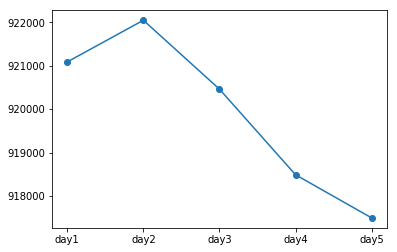

In [60]:
# plot scores
days = ['day1', 'day2', 'day3', 'day4', 'day5']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [61]:
print(predictions)

[[963.46106499 962.88685551 961.17096537 958.94926918 957.28909519
           nan          nan          nan          nan          nan]
 [957.2425335  958.81726578 958.86345205 959.03428733 959.60804439
           nan          nan          nan          nan          nan]]


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

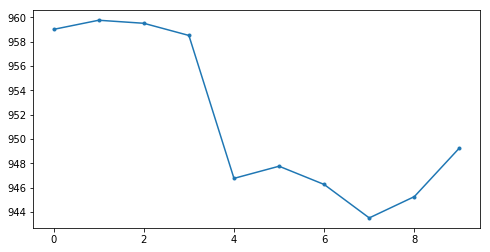

In [64]:
aa=[x for x in range(10)]
plt.figure(figsize=(8,4))
plt.plot(aa, dataset['Close'].tail(10).values, marker='.', label="actual")
plt.plot(aa, array(predictions).reshape(1,-1)[0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [65]:
train_x.shape

(471, 10, 21)

In [66]:
array(predictions).reshape(1,-1)[0]

array([963.46106499, 962.88685551, 961.17096537, 958.94926918,
       957.28909519,          nan,          nan,          nan,
                nan,          nan, 957.2425335 , 958.81726578,
       958.86345205, 959.03428733, 959.60804439,          nan,
                nan,          nan,          nan,          nan])

In [67]:
train_y.shape

(471, 5, 1)

In [68]:
predictions, dataset['Close'].tail(5)

(array([[963.46106499, 962.88685551, 961.17096537, 958.94926918,
         957.28909519,          nan,          nan,          nan,
                  nan,          nan],
        [957.2425335 , 958.81726578, 958.86345205, 959.03428733,
         959.60804439,          nan,          nan,          nan,
                  nan,          nan]]), Time
 2019-10-28    947.75
 2019-10-29    946.25
 2019-10-30    943.50
 2019-10-31    945.25
 2019-11-01    949.25
 Name: Close, dtype: float64)

In [366]:
l = []
for i in predictions:
    for j in i:
        l.append(j)
    

In [367]:
l

[925.4829282462597,
 921.3684132695198,
 918.0270081013441,
 916.658183991909,
 916.1825366616249,
 931.4887699484825,
 923.5779131352901,
 919.3191888034344,
 915.9938256144524,
 914.4500029087067,
 941.3713992238045,
 931.2631522417068,
 925.0214554220438,
 920.876651763916,
 918.6338069140911,
 931.107651412487,
 924.8737469613552,
 920.3525752723217,
 917.8590750992298,
 916.2842658162117,
 928.7901798337698,
 922.2251887619495,
 918.5365924239159,
 916.107650026679,
 914.9456100612879,
 926.9503241330385,
 922.452183008194,
 918.6350775659084,
 915.408709704876,
 913.8637222349644,
 918.5872644782066,
 914.4213651120663,
 912.389535099268,
 911.1892456263304,
 910.8899108618498,
 907.1110886186361,
 906.6987332254648,
 907.0602481067181,
 907.019601687789,
 907.1384894549847,
 902.8543039560318,
 906.6876583397388,
 909.6470786184072,
 911.0371861457825,
 911.6024769991636,
 908.2335987985134,
 904.3678620457649,
 900.7231031954288,
 898.2716981768608,
 896.497824922204,
 908.2957

In [370]:
actual = dataset['Close'].tail(100).values

array([947.75, 946.25, 943.5 , 945.25, 949.25])

In [369]:
actual[-5:]

array([947.75, 946.25, 943.5 , 945.25, 949.25])

In [371]:
predictions[-1]

array([961.60719362, 960.18596956, 955.23777223, 950.89545441,
       947.63539502])

In [368]:
l-actual

array([-8.51707175e+00, -1.96315867e+01, -3.64729919e+01, -3.90918160e+01,
       -3.13174633e+01, -2.87612301e+01, -2.34220869e+01, -3.26808112e+01,
       -2.82561744e+01, -2.22999971e+01,  9.62139922e+00, -1.02368478e+01,
       -3.72854458e+00,  1.37665176e+00, -1.03661931e+01,  1.58576514e+01,
        6.12374696e+00, -5.39742473e+00, -1.63909249e+01, -2.22157342e+01,
       -2.32098202e+01, -1.87748112e+01, -8.96340758e+00, -6.39234997e+00,
       -6.30438994e+00, -1.35496759e+01, -5.79781699e+00, -7.61492243e+00,
       -1.55912903e+01, -1.06362778e+01, -7.16273552e+00, -1.48286349e+01,
       -9.86046490e+00,  2.68924563e+00,  1.91399109e+01,  1.28610886e+01,
        1.29487332e+01,  1.63102481e+01,  1.52696017e+01, -3.61510545e-01,
       -1.31456960e+01,  1.43765834e+00, -4.35292138e+00,  7.28718615e+00,
        1.46024770e+01,  1.73359880e+00,  1.06178620e+01,  5.47310320e+00,
       -1.97830182e+00,  9.97824922e-01,  2.30457308e+01,  2.22106050e+01,
        3.29333927e+01,  